In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    #rewards__ = tf.square(e_next_states_logits - next_states) 
    next_states_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                               labels=next_states_labels)
    rewards_in = tf.reduce_mean(tf.reduce_sum(next_states_loss, axis=1))
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2, rewards_in

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, self.rewards_in = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            #rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:0.6898 eloss:2.2634 aloss2:3.5952 exploreP:0.9979
Episode:1 meanR:20.0000 R:19.0000 rate:0.0380 aloss:0.7167 eloss:2.2192 aloss2:3.6715 exploreP:0.9960
Episode:2 meanR:20.6667 R:22.0000 rate:0.0440 aloss:0.6881 eloss:2.2880 aloss2:3.5672 exploreP:0.9939
Episode:3 meanR:18.7500 R:13.0000 rate:0.0260 aloss:0.6902 eloss:2.2698 aloss2:3.5856 exploreP:0.9926
Episode:4 meanR:17.8000 R:14.0000 rate:0.0280 aloss:0.6928 eloss:2.2464 aloss2:3.6339 exploreP:0.9912
Episode:5 meanR:18.5000 R:22.0000 rate:0.0440 aloss:0.6893 eloss:2.2844 aloss2:3.5914 exploreP:0.9891
Episode:6 meanR:18.1429 R:16.0000 rate:0.0320 aloss:0.6869 eloss:2.2638 aloss2:3.6259 exploreP:0.9875
Episode:7 meanR:18.3750 R:20.0000 rate:0.0400 aloss:0.6908 eloss:2.2837 aloss2:3.6227 exploreP:0.9856
Episode:8 meanR:17.4444 R:10.0000 rate:0.0200 aloss:0.6894 eloss:2.3312 aloss2:3.5479 exploreP:0.9846
Episode:9 meanR:17.6000 R:19.0000 rate:0.0380 aloss:0.7014 eloss:2.2456 aloss2:3.7

Episode:80 meanR:29.2222 R:29.0000 rate:0.0580 aloss:0.6761 eloss:0.6891 aloss2:5.8097 exploreP:0.7913
Episode:81 meanR:29.5122 R:53.0000 rate:0.1060 aloss:0.6751 eloss:0.6777 aloss2:5.8823 exploreP:0.7872
Episode:82 meanR:29.2771 R:10.0000 rate:0.0200 aloss:0.6838 eloss:0.6327 aloss2:6.0271 exploreP:0.7864
Episode:83 meanR:29.3810 R:38.0000 rate:0.0760 aloss:0.6769 eloss:0.6274 aloss2:5.9449 exploreP:0.7835
Episode:84 meanR:30.0353 R:85.0000 rate:0.1700 aloss:0.6831 eloss:0.5618 aloss2:6.1856 exploreP:0.7769
Episode:85 meanR:30.0000 R:27.0000 rate:0.0540 aloss:0.6776 eloss:0.5714 aloss2:6.1437 exploreP:0.7749
Episode:86 meanR:30.1264 R:41.0000 rate:0.0820 aloss:0.6811 eloss:0.5740 aloss2:6.1261 exploreP:0.7717
Episode:87 meanR:30.0682 R:25.0000 rate:0.0500 aloss:0.6818 eloss:0.6120 aloss2:6.0531 exploreP:0.7698
Episode:88 meanR:30.0000 R:24.0000 rate:0.0480 aloss:0.6770 eloss:0.5428 aloss2:6.1056 exploreP:0.7680
Episode:89 meanR:29.8556 R:17.0000 rate:0.0340 aloss:0.6793 eloss:0.4050 

Episode:159 meanR:55.3700 R:21.0000 rate:0.0420 aloss:0.6673 eloss:-2.5281 aloss2:16.2185 exploreP:0.4942
Episode:160 meanR:55.8300 R:77.0000 rate:0.1540 aloss:0.6840 eloss:-2.3484 aloss2:16.0138 exploreP:0.4904
Episode:161 meanR:55.9800 R:61.0000 rate:0.1220 aloss:0.6768 eloss:-2.4117 aloss2:16.4004 exploreP:0.4875
Episode:162 meanR:56.9000 R:110.0000 rate:0.2200 aloss:0.6846 eloss:-2.0949 aloss2:16.5270 exploreP:0.4823
Episode:163 meanR:57.5200 R:76.0000 rate:0.1520 aloss:0.6841 eloss:-2.5254 aloss2:16.5754 exploreP:0.4787
Episode:164 meanR:59.6000 R:246.0000 rate:0.4920 aloss:0.7007 eloss:-2.4803 aloss2:17.2271 exploreP:0.4673
Episode:165 meanR:61.1400 R:218.0000 rate:0.4360 aloss:0.6803 eloss:-2.9114 aloss2:17.9531 exploreP:0.4575
Episode:166 meanR:62.2500 R:161.0000 rate:0.3220 aloss:0.6861 eloss:-2.7616 aloss2:18.6739 exploreP:0.4503
Episode:167 meanR:63.0200 R:122.0000 rate:0.2440 aloss:0.6937 eloss:-3.0931 aloss2:19.1280 exploreP:0.4450
Episode:168 meanR:64.7800 R:205.0000 rate

Episode:236 meanR:174.0100 R:120.0000 rate:0.2400 aloss:0.6866 eloss:-6.7338 aloss2:50.6857 exploreP:0.1149
Episode:237 meanR:174.1300 R:74.0000 rate:0.1480 aloss:0.7111 eloss:-7.7301 aloss2:50.6186 exploreP:0.1141
Episode:238 meanR:174.6200 R:113.0000 rate:0.2260 aloss:0.6988 eloss:-6.2634 aloss2:50.6065 exploreP:0.1130
Episode:239 meanR:174.3300 R:59.0000 rate:0.1180 aloss:0.6837 eloss:-6.5106 aloss2:50.8905 exploreP:0.1124
Episode:240 meanR:175.4300 R:151.0000 rate:0.3020 aloss:0.6965 eloss:-6.8759 aloss2:51.3052 exploreP:0.1108
Episode:241 meanR:175.4000 R:104.0000 rate:0.2080 aloss:0.6721 eloss:-6.2091 aloss2:51.3067 exploreP:0.1098
Episode:242 meanR:176.1700 R:109.0000 rate:0.2180 aloss:0.7018 eloss:-6.1073 aloss2:51.2665 exploreP:0.1087
Episode:243 meanR:176.6200 R:162.0000 rate:0.3240 aloss:0.6836 eloss:-7.2792 aloss2:51.5522 exploreP:0.1071
Episode:244 meanR:174.4700 R:80.0000 rate:0.1600 aloss:0.6991 eloss:-4.7842 aloss2:51.6369 exploreP:0.1063
Episode:245 meanR:175.1300 R:11

Episode:312 meanR:320.7700 R:500.0000 rate:1.0000 aloss:0.6470 eloss:-4.4000 aloss2:59.9085 exploreP:0.0156
Episode:313 meanR:323.0700 R:277.0000 rate:0.5540 aloss:0.6476 eloss:-3.4248 aloss2:60.0880 exploreP:0.0154
Episode:314 meanR:324.7100 R:271.0000 rate:0.5420 aloss:0.6491 eloss:-3.6662 aloss2:59.7097 exploreP:0.0153
Episode:315 meanR:327.8100 R:500.0000 rate:1.0000 aloss:0.6476 eloss:-3.7452 aloss2:59.5617 exploreP:0.0150
Episode:316 meanR:329.4200 R:269.0000 rate:0.5380 aloss:0.6459 eloss:-3.6653 aloss2:59.2318 exploreP:0.0149
Episode:317 meanR:330.9600 R:283.0000 rate:0.5660 aloss:0.6484 eloss:-2.7969 aloss2:58.9098 exploreP:0.0148
Episode:318 meanR:333.0700 R:350.0000 rate:0.7000 aloss:0.6462 eloss:-4.1087 aloss2:58.9577 exploreP:0.0146
Episode:319 meanR:334.6600 R:268.0000 rate:0.5360 aloss:0.6434 eloss:-2.8323 aloss2:59.0315 exploreP:0.0145
Episode:320 meanR:337.9200 R:405.0000 rate:0.8100 aloss:0.6529 eloss:-2.9040 aloss2:58.3272 exploreP:0.0143
Episode:321 meanR:339.9100 R

Episode:388 meanR:374.8600 R:500.0000 rate:1.0000 aloss:0.5633 eloss:-1.6485 aloss2:57.6092 exploreP:0.0104
Episode:389 meanR:372.3600 R:250.0000 rate:0.5000 aloss:0.5709 eloss:-1.9510 aloss2:57.8976 exploreP:0.0104
Episode:390 meanR:373.7900 R:500.0000 rate:1.0000 aloss:0.5671 eloss:-1.8318 aloss2:57.6045 exploreP:0.0104
Episode:391 meanR:372.2000 R:181.0000 rate:0.3620 aloss:0.5788 eloss:-2.5339 aloss2:57.5133 exploreP:0.0104
Episode:392 meanR:369.5800 R:238.0000 rate:0.4760 aloss:0.5664 eloss:-0.9068 aloss2:57.6522 exploreP:0.0103
Episode:393 meanR:369.5800 R:500.0000 rate:1.0000 aloss:0.5710 eloss:-1.0892 aloss2:57.0904 exploreP:0.0103
Episode:394 meanR:367.8600 R:328.0000 rate:0.6560 aloss:0.5481 eloss:-0.4757 aloss2:56.2157 exploreP:0.0103
Episode:395 meanR:368.1100 R:497.0000 rate:0.9940 aloss:0.5588 eloss:-0.3852 aloss2:55.8193 exploreP:0.0103
Episode:396 meanR:365.7900 R:268.0000 rate:0.5360 aloss:0.5642 eloss:-1.8829 aloss2:55.7580 exploreP:0.0103
Episode:397 meanR:365.7900 R

Episode:465 meanR:400.2400 R:439.0000 rate:0.8780 aloss:0.4433 eloss:1.4484 aloss2:37.1140 exploreP:0.0100
Episode:466 meanR:397.2500 R:161.0000 rate:0.3220 aloss:0.4447 eloss:1.0538 aloss2:36.5467 exploreP:0.0100
Episode:467 meanR:395.2000 R:144.0000 rate:0.2880 aloss:0.4458 eloss:1.4056 aloss2:36.8224 exploreP:0.0100
Episode:468 meanR:395.5400 R:500.0000 rate:1.0000 aloss:0.4431 eloss:1.1506 aloss2:36.0642 exploreP:0.0100
Episode:469 meanR:392.3000 R:176.0000 rate:0.3520 aloss:0.4448 eloss:1.1977 aloss2:35.6576 exploreP:0.0100
Episode:470 meanR:391.2800 R:174.0000 rate:0.3480 aloss:0.4441 eloss:1.0713 aloss2:35.4628 exploreP:0.0100
Episode:471 meanR:388.5700 R:157.0000 rate:0.3140 aloss:0.4446 eloss:1.2944 aloss2:35.0077 exploreP:0.0100
Episode:472 meanR:386.0900 R:252.0000 rate:0.5040 aloss:0.4389 eloss:0.9683 aloss2:34.8584 exploreP:0.0100
Episode:473 meanR:386.0900 R:500.0000 rate:1.0000 aloss:0.4434 eloss:1.2336 aloss2:34.6078 exploreP:0.0100
Episode:474 meanR:382.5800 R:149.0000

Episode:542 meanR:350.1800 R:500.0000 rate:1.0000 aloss:0.4125 eloss:1.1140 aloss2:14.4650 exploreP:0.0100
Episode:543 meanR:346.8400 R:166.0000 rate:0.3320 aloss:0.4143 eloss:1.0751 aloss2:14.3586 exploreP:0.0100
Episode:544 meanR:343.4000 R:156.0000 rate:0.3120 aloss:0.4118 eloss:1.0320 aloss2:14.4044 exploreP:0.0100
Episode:545 meanR:343.4000 R:500.0000 rate:1.0000 aloss:0.4140 eloss:1.1086 aloss2:14.3040 exploreP:0.0100
Episode:546 meanR:346.0300 R:500.0000 rate:1.0000 aloss:0.4142 eloss:1.0999 aloss2:14.2614 exploreP:0.0100
Episode:547 meanR:349.0300 R:500.0000 rate:1.0000 aloss:0.4102 eloss:1.0457 aloss2:14.2232 exploreP:0.0100
Episode:548 meanR:349.0300 R:500.0000 rate:1.0000 aloss:0.4158 eloss:1.1086 aloss2:14.1479 exploreP:0.0100
Episode:549 meanR:349.0300 R:500.0000 rate:1.0000 aloss:0.4139 eloss:1.0783 aloss2:14.0186 exploreP:0.0100
Episode:550 meanR:348.4000 R:162.0000 rate:0.3240 aloss:0.4132 eloss:1.0892 aloss2:13.7854 exploreP:0.0100
Episode:551 meanR:348.4000 R:500.0000

Episode:619 meanR:428.8600 R:500.0000 rate:1.0000 aloss:0.4265 eloss:1.1437 aloss2:11.4099 exploreP:0.0100
Episode:620 meanR:428.8200 R:145.0000 rate:0.2900 aloss:0.4291 eloss:1.1280 aloss2:11.3791 exploreP:0.0100
Episode:621 meanR:428.8200 R:500.0000 rate:1.0000 aloss:0.4263 eloss:1.1269 aloss2:11.4154 exploreP:0.0100
Episode:622 meanR:428.8200 R:500.0000 rate:1.0000 aloss:0.4274 eloss:1.1227 aloss2:11.4783 exploreP:0.0100
Episode:623 meanR:428.8200 R:500.0000 rate:1.0000 aloss:0.4263 eloss:1.1301 aloss2:11.5279 exploreP:0.0100
Episode:624 meanR:428.8200 R:500.0000 rate:1.0000 aloss:0.4233 eloss:1.1194 aloss2:11.5714 exploreP:0.0100
Episode:625 meanR:428.8200 R:500.0000 rate:1.0000 aloss:0.4257 eloss:1.1202 aloss2:11.6689 exploreP:0.0100
Episode:626 meanR:428.8200 R:500.0000 rate:1.0000 aloss:0.4231 eloss:1.1012 aloss2:11.7386 exploreP:0.0100
Episode:627 meanR:428.8200 R:500.0000 rate:1.0000 aloss:0.4241 eloss:1.1089 aloss2:11.8657 exploreP:0.0100
Episode:628 meanR:428.8200 R:500.0000

Episode:696 meanR:469.4400 R:500.0000 rate:1.0000 aloss:0.4126 eloss:-0.6674 aloss2:29.2431 exploreP:0.0100
Episode:697 meanR:469.4400 R:500.0000 rate:1.0000 aloss:0.4377 eloss:-0.6839 aloss2:29.7570 exploreP:0.0100
Episode:698 meanR:469.0100 R:457.0000 rate:0.9140 aloss:0.4140 eloss:-0.7091 aloss2:30.0885 exploreP:0.0100
Episode:699 meanR:469.0100 R:500.0000 rate:1.0000 aloss:0.4316 eloss:-0.7461 aloss2:30.5970 exploreP:0.0100
Episode:700 meanR:466.8900 R:288.0000 rate:0.5760 aloss:0.4169 eloss:-0.7623 aloss2:30.8444 exploreP:0.0100
Episode:701 meanR:470.2900 R:500.0000 rate:1.0000 aloss:0.4111 eloss:-0.8136 aloss2:31.2924 exploreP:0.0100
Episode:702 meanR:470.2900 R:500.0000 rate:1.0000 aloss:0.4078 eloss:-0.9073 aloss2:31.8305 exploreP:0.0100
Episode:703 meanR:470.5800 R:500.0000 rate:1.0000 aloss:0.4052 eloss:-1.0059 aloss2:32.4732 exploreP:0.0100
Episode:704 meanR:470.5800 R:500.0000 rate:1.0000 aloss:0.4321 eloss:-0.8419 aloss2:33.1062 exploreP:0.0100
Episode:705 meanR:465.9400 R

Episode:772 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3706 eloss:-4.1084 aloss2:79.3607 exploreP:0.0100
Episode:773 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3693 eloss:-4.1200 aloss2:79.8830 exploreP:0.0100
Episode:774 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3689 eloss:-4.2167 aloss2:80.5409 exploreP:0.0100
Episode:775 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3685 eloss:-4.2935 aloss2:81.1737 exploreP:0.0100
Episode:776 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3664 eloss:-4.3747 aloss2:81.7802 exploreP:0.0100
Episode:777 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3674 eloss:-4.3691 aloss2:82.3061 exploreP:0.0100
Episode:778 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3660 eloss:-4.3901 aloss2:82.8964 exploreP:0.0100
Episode:779 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3674 eloss:-4.4957 aloss2:83.6163 exploreP:0.0100
Episode:780 meanR:461.0000 R:500.0000 rate:1.0000 aloss:0.3657 eloss:-4.4541 aloss2:84.0802 exploreP:0.0100
Episode:781 meanR:465.7400 R

Episode:848 meanR:490.4300 R:500.0000 rate:1.0000 aloss:0.3475 eloss:-6.6435 aloss2:123.5763 exploreP:0.0100
Episode:849 meanR:490.4300 R:500.0000 rate:1.0000 aloss:0.3467 eloss:-6.7380 aloss2:123.9421 exploreP:0.0100
Episode:850 meanR:490.4300 R:500.0000 rate:1.0000 aloss:0.3473 eloss:-6.8503 aloss2:124.5250 exploreP:0.0100
Episode:851 meanR:490.4300 R:500.0000 rate:1.0000 aloss:0.3463 eloss:-6.8654 aloss2:124.8669 exploreP:0.0100
Episode:852 meanR:490.4300 R:500.0000 rate:1.0000 aloss:0.3454 eloss:-6.9487 aloss2:125.3329 exploreP:0.0100
Episode:853 meanR:490.4300 R:500.0000 rate:1.0000 aloss:0.3459 eloss:-6.9182 aloss2:125.7431 exploreP:0.0100
Episode:854 meanR:495.2100 R:500.0000 rate:1.0000 aloss:0.3457 eloss:-6.9578 aloss2:126.2504 exploreP:0.0100
Episode:855 meanR:495.2100 R:500.0000 rate:1.0000 aloss:0.3453 eloss:-7.1211 aloss2:126.5824 exploreP:0.0100
Episode:856 meanR:495.2100 R:500.0000 rate:1.0000 aloss:0.3452 eloss:-7.1074 aloss2:127.0764 exploreP:0.0100
Episode:857 meanR:4

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

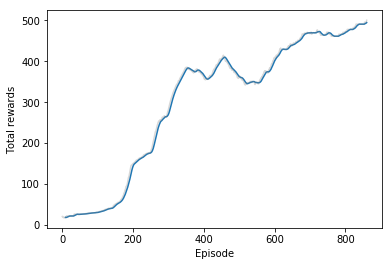

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

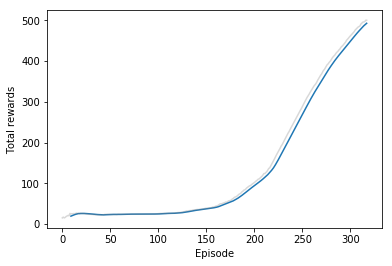

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

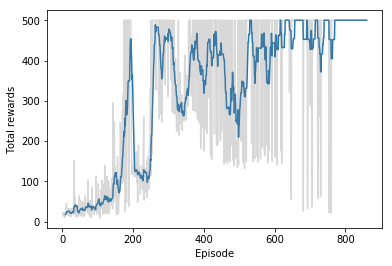

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

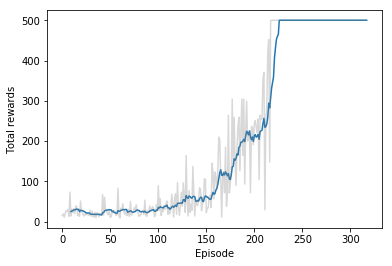

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

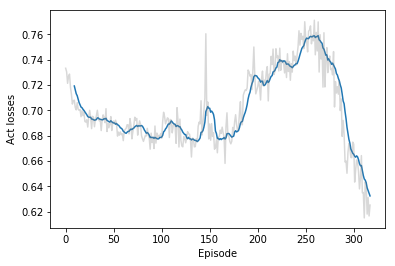

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

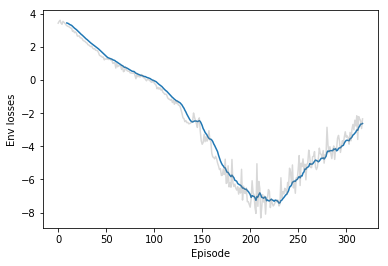

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

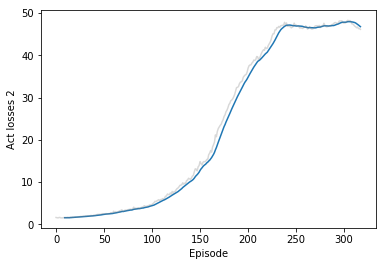

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
